# 0. Load data and select only the records corresponding to failed inspection (see "results" column)

In [1]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer
import string
from collections import Counter

In [2]:
# import data
import csv
df = pd.read_csv('Food_Inspections_20240108.csv')
df.head(10)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2587633,TACOS MARIO'S LIMITED,TACOS MARIO'S LIMITED,1447643.0,Restaurant,Risk 1 (High),4540 W 63RD ST,CHICAGO,IL,60629.0,01/04/2024,Non-Inspection,No Entry,NaN,41.778606,-87.736592,"(41.77860614662516, -87.73659163763277)"
1,2587625,"TAQUERIA EL ARCO #3 EL POLLO FELIZ, INC.",EL POLLO CRIS CRIS #3,1964458.0,Restaurant,Risk 1 (High),7023-7025 S PULASKI RD,CHICAGO,IL,60629.0,01/04/2024,Canvass,Out of Business,NaN,41.765126,-87.722279,"(41.765126421774134, -87.72227898862089)"
2,2587598,Tel Aviv Slices Pizza LLC,Tel Aviv Slices Pizza LLC,2948183.0,NaN,Risk 1 (High),3517 W DEVON AVE,CHICAGO,IL,60659.0,01/04/2024,License,Not Ready,NaN,41.997177,-87.717388,"(41.99717696905116, -87.71738760229222)"
3,2587596,KENSINGTON SCHOOL OF LINCOLN PARK,KENSINGTON SCHOOL OF LINCOLN PARK,2944036.0,Children's Services Facility,Risk 1 (High),2745 N LINCOLN AVE,CHICAGO,IL,60614.0,01/04/2024,License,Pass,NaN,41.931779,-87.657407,"(41.93177936843524, -87.65740695216547)"
4,2587599,Q'S AUTHENTIC COOKING,Q'S AUTHENTIC COOKING,2757521.0,Restaurant,Risk 1 (High),306 E 75TH ST,CHICAGO,IL,60619.0,01/04/2024,Canvass,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",41.758467,-87.617974,"(41.75846743102775, -87.61797380173462)"
5,2587579,SUBWAY,SUBWAY,1719251.0,Restaurant,Risk 1 (High),10354 S HALSTED ST,CHICAGO,IL,60628.0,01/04/2024,Canvass,Out of Business,NaN,41.705296,-87.642931,"(41.705296492547895, -87.64293095094614)"
6,2587551,WE ARE THE FUTURE PRESIDENTS,WE ARE THE FUTURE PRESIDENTS,2578250.0,Daycare Above and Under 2 Years,Risk 1 (High),843-847 W 103RD ST,CHICAGO,IL,60643.0,12/29/2023,License,No Entry,NaN,41.706792,-87.644524,"(41.706792177425825, -87.64452365930406)"
7,2587527,ST. ANTHONY HOSPITAL,PATIENT KITCHEN/PREP AREA,2204412.0,Hospital,Risk 1 (High),2875 W 19TH ST,CHICAGO,IL,60623.0,12/29/2023,Canvass Re-Inspection,Pass,51. PLUMBING INSTALLED; PROPER BACKFLOW DEVICE...,41.855403,-87.698708,"(41.85540289350027, -87.69870754487314)"
8,2587465,PROVARE CHICAGO,PROVARE CHICAGO,2796734.0,Restaurant,Risk 1 (High),1421 W CHICAGO AVE,CHICAGO,IL,60642.0,12/28/2023,Canvass,Out of Business,NaN,41.896025,-87.663272,"(41.89602502708334, -87.66327229348566)"
9,2587467,ICOLDTEA,ICOLDTEA,2886816.0,Restaurant,Risk 2 (Medium),1122 W WILSON AVE,CHICAGO,IL,60640.0,12/28/2023,Canvass,Out of Business,NaN,41.965497,-87.658403,"(41.965497036127346, -87.65840280954839)"


In [3]:
df.shape

(265653, 17)

In [4]:
# Select only the records where the inspection result is 'Fail'
failed_inspections = df[df['Results'] == 'Fail']

# Display the DataFrame with only failed inspections
failed_inspections.head(10)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
43,2587039,"SORA TEMAKERIA, LLC","SORA TEMAKERIA, LLC",2569202.0,Restaurant,Risk 1 (High),3508 W 26TH ST,CHICAGO,IL,60623.0,12/15/2023,Canvass Re-Inspection,Fail,59. PREVIOUS PRIORITY FOUNDATION VIOLATION COR...,41.844516,-87.712776,"(41.84451619427469, -87.71277572197552)"
47,2586974,CAFE 1850,CAFE 1850,2590022.0,Restaurant,Risk 1 (High),1850 W ROOSEVELT RD,CHICAGO,IL,60608.0,12/14/2023,Canvass,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.866906,-87.673316,"(41.86690583756181, -87.6733159162735)"
57,2586823,ALL ABOUT KIDS LEARNING ACADEMY,ALL ABOUT KIDS LEARNING ACADEMY,2384881.0,Children's Services Facility,Risk 1 (High),504-516 E 75TH ST,CHICAGO,IL,60619.0,12/12/2023,Canvass,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.758567,-87.612451,"(41.758566800153645, -87.61245073862713)"
65,2586749,BLISS BOWLS INC,BLISS BOWLS,2943819.0,Restaurant,Risk 2 (Medium),557 W DIVERSEY PKWY,CHICAGO,IL,60614.0,12/12/2023,License,Fail,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.932721,-87.643354,"(41.932721491859006, -87.64335421876027)"
86,2586498,STEVE'S LOUNGE,STEVE'S LOUNGE,833.0,Restaurant,Risk 1 (High),13200 S BALTIMORE AVE,CHICAGO,IL,60633.0,12/07/2023,Complaint Re-Inspection,Fail,59. PREVIOUS PRIORITY FOUNDATION VIOLATION COR...,41.655417,-87.547291,"(41.655416650555715, -87.54729079495272)"
99,2586400,NOOKIES ON WELLS INC,NOOKIES ON WELLS,26855.0,Restaurant,Risk 1 (High),1746 N WELLS ST,CHICAGO,IL,60614.0,12/06/2023,Suspected Food Poisoning,Fail,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,41.914219,-87.634952,"(41.914218841678505, -87.63495182369267)"
107,2586344,GREEN TEA JAPANESE RESTAURANT,GREEN TEA JAPANESE RESTAURANT,1044031.0,Restaurant,Risk 1 (High),2206 N CLARK ST,CHICAGO,IL,60614.0,12/05/2023,Canvass,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.922146,-87.638546,"(41.922146045915134, -87.63854595404018)"
115,2586237,SENORITAS CANTINA,SENORITAS CANTINA,2797674.0,Restaurant,Risk 1 (High),610 S DEARBORN ST,CHICAGO,IL,60605.0,12/04/2023,Canvass,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.874327,-87.629356,"(41.8743270495379, -87.62935647953225)"
118,2586229,SKYWAY DOG HOUSE INC,SKYWAY DOG HOUSE INC,3558.0,Restaurant,Risk 2 (Medium),9480 S EWING AVE,CHICAGO,IL,60617.0,12/04/2023,Complaint Re-Inspection,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.723035,-87.536792,"(41.72303512369261, -87.53679203497643)"
123,2586180,BIG BOWL,BIG BOWL (T5/M7),2192971.0,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,60666.0,12/04/2023,Complaint,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)"


In [5]:
failed_inspections.shape

(51841, 17)

# 1. Clean the data, making sure that there are no NaNs in "violations" column

In [6]:
# Drop rows with NaN values in the "violations" column
df_cleaned = failed_inspections.dropna(subset=['Violations'])
df_cleaned.head(10)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
43,2587039,"SORA TEMAKERIA, LLC","SORA TEMAKERIA, LLC",2569202.0,Restaurant,Risk 1 (High),3508 W 26TH ST,CHICAGO,IL,60623.0,12/15/2023,Canvass Re-Inspection,Fail,59. PREVIOUS PRIORITY FOUNDATION VIOLATION COR...,41.844516,-87.712776,"(41.84451619427469, -87.71277572197552)"
47,2586974,CAFE 1850,CAFE 1850,2590022.0,Restaurant,Risk 1 (High),1850 W ROOSEVELT RD,CHICAGO,IL,60608.0,12/14/2023,Canvass,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.866906,-87.673316,"(41.86690583756181, -87.6733159162735)"
57,2586823,ALL ABOUT KIDS LEARNING ACADEMY,ALL ABOUT KIDS LEARNING ACADEMY,2384881.0,Children's Services Facility,Risk 1 (High),504-516 E 75TH ST,CHICAGO,IL,60619.0,12/12/2023,Canvass,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.758567,-87.612451,"(41.758566800153645, -87.61245073862713)"
65,2586749,BLISS BOWLS INC,BLISS BOWLS,2943819.0,Restaurant,Risk 2 (Medium),557 W DIVERSEY PKWY,CHICAGO,IL,60614.0,12/12/2023,License,Fail,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.932721,-87.643354,"(41.932721491859006, -87.64335421876027)"
86,2586498,STEVE'S LOUNGE,STEVE'S LOUNGE,833.0,Restaurant,Risk 1 (High),13200 S BALTIMORE AVE,CHICAGO,IL,60633.0,12/07/2023,Complaint Re-Inspection,Fail,59. PREVIOUS PRIORITY FOUNDATION VIOLATION COR...,41.655417,-87.547291,"(41.655416650555715, -87.54729079495272)"
99,2586400,NOOKIES ON WELLS INC,NOOKIES ON WELLS,26855.0,Restaurant,Risk 1 (High),1746 N WELLS ST,CHICAGO,IL,60614.0,12/06/2023,Suspected Food Poisoning,Fail,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,41.914219,-87.634952,"(41.914218841678505, -87.63495182369267)"
107,2586344,GREEN TEA JAPANESE RESTAURANT,GREEN TEA JAPANESE RESTAURANT,1044031.0,Restaurant,Risk 1 (High),2206 N CLARK ST,CHICAGO,IL,60614.0,12/05/2023,Canvass,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.922146,-87.638546,"(41.922146045915134, -87.63854595404018)"
115,2586237,SENORITAS CANTINA,SENORITAS CANTINA,2797674.0,Restaurant,Risk 1 (High),610 S DEARBORN ST,CHICAGO,IL,60605.0,12/04/2023,Canvass,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.874327,-87.629356,"(41.8743270495379, -87.62935647953225)"
118,2586229,SKYWAY DOG HOUSE INC,SKYWAY DOG HOUSE INC,3558.0,Restaurant,Risk 2 (Medium),9480 S EWING AVE,CHICAGO,IL,60617.0,12/04/2023,Complaint Re-Inspection,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.723035,-87.536792,"(41.72303512369261, -87.53679203497643)"
123,2586180,BIG BOWL,BIG BOWL (T5/M7),2192971.0,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,60666.0,12/04/2023,Complaint,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)"


In [7]:
df_cleaned.shape

(48413, 17)

### NOTE: "Violations" column lists the reasons for inspection failure. Those reasons are separated by "|".  <br> Each reason consists of a regulation code, regulation description, and comments describing how the regulation was violated.

# 2. Using regular expression, parse "violations" column to select only regulation descriptions, no code or comments

In [42]:
# Define a regular expression pattern to extract the regulation descriptions
regulation_description_pattern = r'\d+\.\s*([^|]+) - Comments:'

# Apply the regular expression and create a new column with only the regulation descriptions
df_cleaned['violation description'] = df_cleaned['Violations'].str.findall(regulation_description_pattern)

# Display the DataFrame with the new column
df_cleaned.head(10)

/var/folders/5m/4lhv4ytx7yj3s466mgvgfz4c0000gn/T/ipykernel_41872/715306384.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['violation description'] = df_cleaned['Violations'].str.findall(regulation_description_pattern)


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,violation description
43,2587039,"SORA TEMAKERIA, LLC","SORA TEMAKERIA, LLC",2569202.0,Restaurant,Risk 1 (High),3508 W 26TH ST,CHICAGO,IL,60623.0,12/15/2023,Canvass Re-Inspection,Fail,59. PREVIOUS PRIORITY FOUNDATION VIOLATION COR...,41.844516,-87.712776,"(41.84451619427469, -87.71277572197552)",[PREVIOUS PRIORITY FOUNDATION VIOLATION CORREC...
47,2586974,CAFE 1850,CAFE 1850,2590022.0,Restaurant,Risk 1 (High),1850 W ROOSEVELT RD,CHICAGO,IL,60608.0,12/14/2023,Canvass,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.866906,-87.673316,"(41.86690583756181, -87.6733159162735)",[ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED ...
57,2586823,ALL ABOUT KIDS LEARNING ACADEMY,ALL ABOUT KIDS LEARNING ACADEMY,2384881.0,Children's Services Facility,Risk 1 (High),504-516 E 75TH ST,CHICAGO,IL,60619.0,12/12/2023,Canvass,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.758567,-87.612451,"(41.758566800153645, -87.61245073862713)",[ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED ...
65,2586749,BLISS BOWLS INC,BLISS BOWLS,2943819.0,Restaurant,Risk 2 (Medium),557 W DIVERSEY PKWY,CHICAGO,IL,60614.0,12/12/2023,License,Fail,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.932721,-87.643354,"(41.932721491859006, -87.64335421876027)",[PROCEDURES FOR RESPONDING TO VOMITING AND DIA...
86,2586498,STEVE'S LOUNGE,STEVE'S LOUNGE,833.0,Restaurant,Risk 1 (High),13200 S BALTIMORE AVE,CHICAGO,IL,60633.0,12/07/2023,Complaint Re-Inspection,Fail,59. PREVIOUS PRIORITY FOUNDATION VIOLATION COR...,41.655417,-87.547291,"(41.655416650555715, -87.54729079495272)",[PREVIOUS PRIORITY FOUNDATION VIOLATION CORREC...
99,2586400,NOOKIES ON WELLS INC,NOOKIES ON WELLS,26855.0,Restaurant,Risk 1 (High),1746 N WELLS ST,CHICAGO,IL,60614.0,12/06/2023,Suspected Food Poisoning,Fail,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,41.914219,-87.634952,"(41.914218841678505, -87.63495182369267)",[CITY OF CHICAGO FOOD SERVICE SANITATION CERTI...
107,2586344,GREEN TEA JAPANESE RESTAURANT,GREEN TEA JAPANESE RESTAURANT,1044031.0,Restaurant,Risk 1 (High),2206 N CLARK ST,CHICAGO,IL,60614.0,12/05/2023,Canvass,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.922146,-87.638546,"(41.922146045915134, -87.63854595404018)","[PERSON IN CHARGE PRESENT, DEMONSTRATES KNOWLE..."
115,2586237,SENORITAS CANTINA,SENORITAS CANTINA,2797674.0,Restaurant,Risk 1 (High),610 S DEARBORN ST,CHICAGO,IL,60605.0,12/04/2023,Canvass,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.874327,-87.629356,"(41.8743270495379, -87.62935647953225)","[PERSON IN CHARGE PRESENT, DEMONSTRATES KNOWLE..."
118,2586229,SKYWAY DOG HOUSE INC,SKYWAY DOG HOUSE INC,3558.0,Restaurant,Risk 2 (Medium),9480 S EWING AVE,CHICAGO,IL,60617.0,12/04/2023,Complaint Re-Inspection,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.723035,-87.536792,"(41.72303512369261, -87.53679203497643)","[MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMP..."
123,2586180,BIG BOWL,BIG BOWL (T5/M7),2192971.0,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,60666.0,12/04/2023,Complaint,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)",[ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED ...


In [8]:
df_cleaned['violation description'] = df_cleaned['Violations'].apply(lambda x: re.findall(r'\d+\.\s*([^|]+) - Comments:',str(x)))
df_cleaned.head(10)

/var/folders/5m/4lhv4ytx7yj3s466mgvgfz4c0000gn/T/ipykernel_43555/1812518674.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['violation description'] = df_cleaned['Violations'].apply(lambda x: re.findall(r'\d+\.\s*([^|]+) - Comments:',str(x)))


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,violation description
43,2587039,"SORA TEMAKERIA, LLC","SORA TEMAKERIA, LLC",2569202.0,Restaurant,Risk 1 (High),3508 W 26TH ST,CHICAGO,IL,60623.0,12/15/2023,Canvass Re-Inspection,Fail,59. PREVIOUS PRIORITY FOUNDATION VIOLATION COR...,41.844516,-87.712776,"(41.84451619427469, -87.71277572197552)",[PREVIOUS PRIORITY FOUNDATION VIOLATION CORREC...
47,2586974,CAFE 1850,CAFE 1850,2590022.0,Restaurant,Risk 1 (High),1850 W ROOSEVELT RD,CHICAGO,IL,60608.0,12/14/2023,Canvass,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.866906,-87.673316,"(41.86690583756181, -87.6733159162735)",[ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED ...
57,2586823,ALL ABOUT KIDS LEARNING ACADEMY,ALL ABOUT KIDS LEARNING ACADEMY,2384881.0,Children's Services Facility,Risk 1 (High),504-516 E 75TH ST,CHICAGO,IL,60619.0,12/12/2023,Canvass,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.758567,-87.612451,"(41.758566800153645, -87.61245073862713)",[ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED ...
65,2586749,BLISS BOWLS INC,BLISS BOWLS,2943819.0,Restaurant,Risk 2 (Medium),557 W DIVERSEY PKWY,CHICAGO,IL,60614.0,12/12/2023,License,Fail,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.932721,-87.643354,"(41.932721491859006, -87.64335421876027)",[PROCEDURES FOR RESPONDING TO VOMITING AND DIA...
86,2586498,STEVE'S LOUNGE,STEVE'S LOUNGE,833.0,Restaurant,Risk 1 (High),13200 S BALTIMORE AVE,CHICAGO,IL,60633.0,12/07/2023,Complaint Re-Inspection,Fail,59. PREVIOUS PRIORITY FOUNDATION VIOLATION COR...,41.655417,-87.547291,"(41.655416650555715, -87.54729079495272)",[PREVIOUS PRIORITY FOUNDATION VIOLATION CORREC...
99,2586400,NOOKIES ON WELLS INC,NOOKIES ON WELLS,26855.0,Restaurant,Risk 1 (High),1746 N WELLS ST,CHICAGO,IL,60614.0,12/06/2023,Suspected Food Poisoning,Fail,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,41.914219,-87.634952,"(41.914218841678505, -87.63495182369267)",[CITY OF CHICAGO FOOD SERVICE SANITATION CERTI...
107,2586344,GREEN TEA JAPANESE RESTAURANT,GREEN TEA JAPANESE RESTAURANT,1044031.0,Restaurant,Risk 1 (High),2206 N CLARK ST,CHICAGO,IL,60614.0,12/05/2023,Canvass,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.922146,-87.638546,"(41.922146045915134, -87.63854595404018)","[PERSON IN CHARGE PRESENT, DEMONSTRATES KNOWLE..."
115,2586237,SENORITAS CANTINA,SENORITAS CANTINA,2797674.0,Restaurant,Risk 1 (High),610 S DEARBORN ST,CHICAGO,IL,60605.0,12/04/2023,Canvass,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.874327,-87.629356,"(41.8743270495379, -87.62935647953225)","[PERSON IN CHARGE PRESENT, DEMONSTRATES KNOWLE..."
118,2586229,SKYWAY DOG HOUSE INC,SKYWAY DOG HOUSE INC,3558.0,Restaurant,Risk 2 (Medium),9480 S EWING AVE,CHICAGO,IL,60617.0,12/04/2023,Complaint Re-Inspection,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.723035,-87.536792,"(41.72303512369261, -87.53679203497643)","[MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMP..."
123,2586180,BIG BOWL,BIG BOWL (T5/M7),2192971.0,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,60666.0,12/04/2023,Complaint,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)",[ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED ...


In [9]:
print(df_cleaned["violation description"])

43        [PREVIOUS PRIORITY FOUNDATION VIOLATION CORREC...
47        [ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED ...
57        [ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED ...
65        [PROCEDURES FOR RESPONDING TO VOMITING AND DIA...
86        [PREVIOUS PRIORITY FOUNDATION VIOLATION CORREC...
                                ...                        
265633    [SOURCE SOUND CONDITION, NO SPOILAGE, FOODS PR...
265644    [PREVIOUS MINOR VIOLATION(S) CORRECTED 7-42-09...
265645    [WATER SOURCE: SAFE, HOT & COLD UNDER CITY PRE...
265648    [NO EVIDENCE OF RODENT OR INSECT OUTER OPENING...
265650    [PREVIOUS MINOR VIOLATION(S) CORRECTED 7-42-09...
Name: violation description, Length: 48413, dtype: object


In [17]:
df_cleaned.loc[47, 'violation description']

['ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE',
 'ALLERGEN TRAINING AS REQUIRED']

In [46]:
# Define a regular expression pattern to extract the comments
comment_pattern = r'Comments:\s*(.*?)(?=\s*\||$)'

# Apply the regular expression and create a new column with only the regulation descriptions
df_cleaned['comments'] = df_cleaned['Violations'].str.findall(comment_pattern)

# Display the DataFrame with the new column
df_cleaned.head(10)

/var/folders/5m/4lhv4ytx7yj3s466mgvgfz4c0000gn/T/ipykernel_41872/1013731393.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['comments'] = df_cleaned['Violations'].str.findall(comment_pattern)


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,violation description,comments
43,2587039,"SORA TEMAKERIA, LLC","SORA TEMAKERIA, LLC",2569202.0,Restaurant,Risk 1 (High),3508 W 26TH ST,CHICAGO,IL,60623.0,12/15/2023,Canvass Re-Inspection,Fail,59. PREVIOUS PRIORITY FOUNDATION VIOLATION COR...,41.844516,-87.712776,"(41.84451619427469, -87.71277572197552)",[PREVIOUS PRIORITY FOUNDATION VIOLATION CORREC...,[PREVIOUS PRIORITY FOUNDATION NOT CORRECTED FR...
47,2586974,CAFE 1850,CAFE 1850,2590022.0,Restaurant,Risk 1 (High),1850 W ROOSEVELT RD,CHICAGO,IL,60608.0,12/14/2023,Canvass,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.866906,-87.673316,"(41.86690583756181, -87.6733159162735)",[ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED ...,[FOUND CUSTOMER AND EMPLOYEE WOMEN'S AND MEN'S...
57,2586823,ALL ABOUT KIDS LEARNING ACADEMY,ALL ABOUT KIDS LEARNING ACADEMY,2384881.0,Children's Services Facility,Risk 1 (High),504-516 E 75TH ST,CHICAGO,IL,60619.0,12/12/2023,Canvass,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.758567,-87.612451,"(41.758566800153645, -87.61245073862713)",[ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED ...,[OBSERVED HOT RUNNING WATER TEMPERATURE AT HAN...
65,2586749,BLISS BOWLS INC,BLISS BOWLS,2943819.0,Restaurant,Risk 2 (Medium),557 W DIVERSEY PKWY,CHICAGO,IL,60614.0,12/12/2023,License,Fail,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.932721,-87.643354,"(41.932721491859006, -87.64335421876027)",[PROCEDURES FOR RESPONDING TO VOMITING AND DIA...,[NO WRITTEN CLEANING PROCEDURE FOR A VOMIT/DIA...
86,2586498,STEVE'S LOUNGE,STEVE'S LOUNGE,833.0,Restaurant,Risk 1 (High),13200 S BALTIMORE AVE,CHICAGO,IL,60633.0,12/07/2023,Complaint Re-Inspection,Fail,59. PREVIOUS PRIORITY FOUNDATION VIOLATION COR...,41.655417,-87.547291,"(41.655416650555715, -87.54729079495272)",[PREVIOUS PRIORITY FOUNDATION VIOLATION CORREC...,[8-404.13 (B:3) : PREVIOUS PRIORITY FOUNDATION...
99,2586400,NOOKIES ON WELLS INC,NOOKIES ON WELLS,26855.0,Restaurant,Risk 1 (High),1746 N WELLS ST,CHICAGO,IL,60614.0,12/06/2023,Suspected Food Poisoning,Fail,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,41.914219,-87.634952,"(41.914218841678505, -87.63495182369267)",[CITY OF CHICAGO FOOD SERVICE SANITATION CERTI...,[THE PERSON IN CHARGE DURING THE INSPECTION DO...
107,2586344,GREEN TEA JAPANESE RESTAURANT,GREEN TEA JAPANESE RESTAURANT,1044031.0,Restaurant,Risk 1 (High),2206 N CLARK ST,CHICAGO,IL,60614.0,12/05/2023,Canvass,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.922146,-87.638546,"(41.922146045915134, -87.63854595404018)","[PERSON IN CHARGE PRESENT, DEMONSTRATES KNOWLE...",[THE PERSON IN CHARGE DURING THE INITIAL INSPE...
115,2586237,SENORITAS CANTINA,SENORITAS CANTINA,2797674.0,Restaurant,Risk 1 (High),610 S DEARBORN ST,CHICAGO,IL,60605.0,12/04/2023,Canvass,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.874327,-87.629356,"(41.8743270495379, -87.62935647953225)","[PERSON IN CHARGE PRESENT, DEMONSTRATES KNOWLE...",[2-101.11 OBSERVED THE PERSON IN CHARGE WITHOU...
118,2586229,SKYWAY DOG HOUSE INC,SKYWAY DOG HOUSE INC,3558.0,Restaurant,Risk 2 (Medium),9480 S EWING AVE,CHICAGO,IL,60617.0,12/04/2023,Complaint Re-Inspection,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.723035,-87.536792,"(41.72303512369261, -87.53679203497643)","[MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMP...",[OBSERVED NO SIGNED EMPLOYEES HEALTH POLICIES ...
123,2586180,BIG BOWL,BIG BOWL (T5/M7),2192971.0,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,60666.0,12/04/2023,Complaint,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)",[ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED ...,[OBSERVED NO HAND PAPER TOWELS OR HAND DRYING ...


In [11]:
df_cleaned['comments'] = df_cleaned['Violations'].apply(lambda x: re.findall(r'Comments:\s*(.*?)(?=\s*\||$)',str(x)))
df_cleaned.head(10)

/var/folders/5m/4lhv4ytx7yj3s466mgvgfz4c0000gn/T/ipykernel_43555/1789073605.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['comments'] = df_cleaned['Violations'].apply(lambda x: re.findall(r'Comments:\s*(.*?)(?=\s*\||$)',str(x)))


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,violation description,comments
43,2587039,"SORA TEMAKERIA, LLC","SORA TEMAKERIA, LLC",2569202.0,Restaurant,Risk 1 (High),3508 W 26TH ST,CHICAGO,IL,60623.0,12/15/2023,Canvass Re-Inspection,Fail,59. PREVIOUS PRIORITY FOUNDATION VIOLATION COR...,41.844516,-87.712776,"(41.84451619427469, -87.71277572197552)",[PREVIOUS PRIORITY FOUNDATION VIOLATION CORREC...,[PREVIOUS PRIORITY FOUNDATION NOT CORRECTED FR...
47,2586974,CAFE 1850,CAFE 1850,2590022.0,Restaurant,Risk 1 (High),1850 W ROOSEVELT RD,CHICAGO,IL,60608.0,12/14/2023,Canvass,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.866906,-87.673316,"(41.86690583756181, -87.6733159162735)",[ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED ...,[FOUND CUSTOMER AND EMPLOYEE WOMEN'S AND MEN'S...
57,2586823,ALL ABOUT KIDS LEARNING ACADEMY,ALL ABOUT KIDS LEARNING ACADEMY,2384881.0,Children's Services Facility,Risk 1 (High),504-516 E 75TH ST,CHICAGO,IL,60619.0,12/12/2023,Canvass,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.758567,-87.612451,"(41.758566800153645, -87.61245073862713)",[ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED ...,[OBSERVED HOT RUNNING WATER TEMPERATURE AT HAN...
65,2586749,BLISS BOWLS INC,BLISS BOWLS,2943819.0,Restaurant,Risk 2 (Medium),557 W DIVERSEY PKWY,CHICAGO,IL,60614.0,12/12/2023,License,Fail,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.932721,-87.643354,"(41.932721491859006, -87.64335421876027)",[PROCEDURES FOR RESPONDING TO VOMITING AND DIA...,[NO WRITTEN CLEANING PROCEDURE FOR A VOMIT/DIA...
86,2586498,STEVE'S LOUNGE,STEVE'S LOUNGE,833.0,Restaurant,Risk 1 (High),13200 S BALTIMORE AVE,CHICAGO,IL,60633.0,12/07/2023,Complaint Re-Inspection,Fail,59. PREVIOUS PRIORITY FOUNDATION VIOLATION COR...,41.655417,-87.547291,"(41.655416650555715, -87.54729079495272)",[PREVIOUS PRIORITY FOUNDATION VIOLATION CORREC...,[8-404.13 (B:3) : PREVIOUS PRIORITY FOUNDATION...
99,2586400,NOOKIES ON WELLS INC,NOOKIES ON WELLS,26855.0,Restaurant,Risk 1 (High),1746 N WELLS ST,CHICAGO,IL,60614.0,12/06/2023,Suspected Food Poisoning,Fail,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,41.914219,-87.634952,"(41.914218841678505, -87.63495182369267)",[CITY OF CHICAGO FOOD SERVICE SANITATION CERTI...,[THE PERSON IN CHARGE DURING THE INSPECTION DO...
107,2586344,GREEN TEA JAPANESE RESTAURANT,GREEN TEA JAPANESE RESTAURANT,1044031.0,Restaurant,Risk 1 (High),2206 N CLARK ST,CHICAGO,IL,60614.0,12/05/2023,Canvass,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.922146,-87.638546,"(41.922146045915134, -87.63854595404018)","[PERSON IN CHARGE PRESENT, DEMONSTRATES KNOWLE...",[THE PERSON IN CHARGE DURING THE INITIAL INSPE...
115,2586237,SENORITAS CANTINA,SENORITAS CANTINA,2797674.0,Restaurant,Risk 1 (High),610 S DEARBORN ST,CHICAGO,IL,60605.0,12/04/2023,Canvass,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.874327,-87.629356,"(41.8743270495379, -87.62935647953225)","[PERSON IN CHARGE PRESENT, DEMONSTRATES KNOWLE...",[2-101.11 OBSERVED THE PERSON IN CHARGE WITHOU...
118,2586229,SKYWAY DOG HOUSE INC,SKYWAY DOG HOUSE INC,3558.0,Restaurant,Risk 2 (Medium),9480 S EWING AVE,CHICAGO,IL,60617.0,12/04/2023,Complaint Re-Inspection,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.723035,-87.536792,"(41.72303512369261, -87.53679203497643)","[MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMP...",[OBSERVED NO SIGNED EMPLOYEES HEALTH POLICIES ...
123,2586180,BIG BOWL,BIG BOWL (T5/M7),2192971.0,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,60666.0,12/04/2023,Complaint,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)",[ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED ...,[OBSERVED NO HAND PAPER TOWELS OR HAND DRYING ...


In [12]:
print(df_cleaned["comments"])

43        [PREVIOUS PRIORITY FOUNDATION NOT CORRECTED FR...
47        [FOUND CUSTOMER AND EMPLOYEE WOMEN'S AND MEN'S...
57        [OBSERVED HOT RUNNING WATER TEMPERATURE AT HAN...
65        [NO WRITTEN CLEANING PROCEDURE FOR A VOMIT/DIA...
86        [8-404.13 (B:3) : PREVIOUS PRIORITY FOUNDATION...
                                ...                        
265633    [All food shall be from sources approved by he...
265644    [A separate and distinct offense shall be deem...
265645    [All food establishments shall be provided wit...
265648    [All necessary control measures shall be used ...
265650    [A separate and distinct offense shall be deem...
Name: comments, Length: 48413, dtype: object


In [16]:
df_cleaned.loc[47, 'comments']

["FOUND CUSTOMER AND EMPLOYEE WOMEN'S AND MEN'S TOILET ROOM WITHOUT HOT WATER. FOUND WATER TEMPERATURES RANGING FROM 80F - 85F. MUST PROVIDE HOT WATER TEMPERATURE OF 100F AT ALL TIMES. MUST REPAIR AND MAINTAIN. PRIORITY VIOLATION. 7-38-030(C).  CITATION ISSUED",
 'FOUND CITY OF CHICAGO FOOD SERVICE MANAGER WITHOUT PROOF OF ALLERGEN TRAINING ON SITE AT THE TIME OF INSPECTION. INSTRUCTED TO PROVIDE PROOF OF ALLERGEN TRAINING FOR ALL CITY OF CHICAGO FOOD SERVICE MANAGERS.']

# 3. Tokenize violation description and comment columns
# 4. Find top-10 tokens of each column

In [14]:
# Define a function to tokenize a list of strings
def tokenize_list(tokens_list):
    return [word for token in tokens_list for word in word_tokenize(token.lower()) if word not in stopwords.words('english')]

# Apply tokenization to the 'description tokens' column
df_cleaned['description tokens'] = df_cleaned['violation description'].apply(tokenize_list)
df_cleaned.loc[47, 'description tokens']

/var/folders/5m/4lhv4ytx7yj3s466mgvgfz4c0000gn/T/ipykernel_43555/1041057063.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['description tokens'] = df_cleaned['violation description'].apply(tokenize_list)


['adequate',
 'handwashing',
 'sinks',
 'properly',
 'supplied',
 'accessible',
 'allergen',
 'training',
 'required']

In [19]:
# Double check with the violation description
df_cleaned.loc[47, 'violation description']

['ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE',
 'ALLERGEN TRAINING AS REQUIRED']

In [144]:
top_10_description_tokens = df_cleaned['description tokens'].explode().value_counts().head(10)
top_10_description_tokens

description tokens
,              371497
:              128673
maintained      89070
food            89065
&               80027
properly        74328
clean           71258
installed       69061
constructed     68148
equipment       64822
Name: count, dtype: int64

In [23]:
# Apply tokenization to the 'comments tokens' column
df_cleaned['comments tokens'] = df_cleaned['comments'].apply(tokenize_list)
df_cleaned.loc[47, 'comments tokens']

/var/folders/5m/4lhv4ytx7yj3s466mgvgfz4c0000gn/T/ipykernel_43555/148990898.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['comments tokens'] = df_cleaned['comments'].apply(tokenize_list)


['found',
 'customer',
 'employee',
 'women',
 "'s",
 'men',
 "'s",
 'toilet',
 'room',
 'without',
 'hot',
 'water',
 '.',
 'found',
 'water',
 'temperatures',
 'ranging',
 '80f',
 '-',
 '85f',
 '.',
 'must',
 'provide',
 'hot',
 'water',
 'temperature',
 '100f',
 'times',
 '.',
 'must',
 'repair',
 'maintain',
 '.',
 'priority',
 'violation',
 '.',
 '7-38-030',
 '(',
 'c',
 ')',
 '.',
 'citation',
 'issued',
 'found',
 'city',
 'chicago',
 'food',
 'service',
 'manager',
 'without',
 'proof',
 'allergen',
 'training',
 'site',
 'time',
 'inspection',
 '.',
 'instructed',
 'provide',
 'proof',
 'allergen',
 'training',
 'city',
 'chicago',
 'food',
 'service',
 'managers',
 '.']

In [24]:
# Double check with the comments
df_cleaned.loc[47, 'comments']

["FOUND CUSTOMER AND EMPLOYEE WOMEN'S AND MEN'S TOILET ROOM WITHOUT HOT WATER. FOUND WATER TEMPERATURES RANGING FROM 80F - 85F. MUST PROVIDE HOT WATER TEMPERATURE OF 100F AT ALL TIMES. MUST REPAIR AND MAINTAIN. PRIORITY VIOLATION. 7-38-030(C).  CITATION ISSUED",
 'FOUND CITY OF CHICAGO FOOD SERVICE MANAGER WITHOUT PROOF OF ALLERGEN TRAINING ON SITE AT THE TIME OF INSPECTION. INSTRUCTED TO PROVIDE PROOF OF ALLERGEN TRAINING FOR ALL CITY OF CHICAGO FOOD SERVICE MANAGERS.']

In [25]:
top_10_comments_tokens = df_cleaned['comments tokens'].explode().value_counts().head(10)
top_10_comments_tokens

comments tokens
.             722273
,             356067
must          161078
instructed    138092
food          136026
observed      127514
clean         114554
area          105929
maintain       90334
prep           85470
Name: count, dtype: int64

# 5. Clean each column: convert to lower case, remove stopwords, punctuation, numbers, etc

In [74]:
# Function to clean a single string
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove numbers
    text = ''.join(char for char in text if not char.isdigit())
    
    # Remove punctuation
    text = ''.join(char for char in text if char not in string.punctuation)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    text = ' '.join(word for word in tokens if word not in stop_words)
    
    return text
df_cleaned['cleaned description'] = df_cleaned['violation description'].apply(lambda lst: [clean_text(text) for text in lst])
df_cleaned['cleaned comments'] = df_cleaned['comments'].apply(lambda lst: [clean_text(text) for text in lst])
df_cleaned.head(10)

/var/folders/5m/4lhv4ytx7yj3s466mgvgfz4c0000gn/T/ipykernel_43555/3734918969.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cleaned description'] = df_cleaned['violation description'].apply(lambda lst: [clean_text(text) for text in lst])
/var/folders/5m/4lhv4ytx7yj3s466mgvgfz4c0000gn/T/ipykernel_43555/3734918969.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cleaned comments'] = df_cleaned['comments'].apply(lambda lst: [clean_text(text) for text in lst])


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,violation description,comments,description tokens,comments tokens,cleaned description,cleaned comments,cleaned description tokens,cleaned comments tokens,descriptions PorterStem tokens,comments PorterStem tokens
43,2587039,"SORA TEMAKERIA, LLC","SORA TEMAKERIA, LLC",2569202.0,Restaurant,Risk 1 (High),3508 W 26TH ST,CHICAGO,IL,60623.0,...,[PREVIOUS PRIORITY FOUNDATION VIOLATION CORREC...,[PREVIOUS PRIORITY FOUNDATION NOT CORRECTED FR...,"[previous, priority, foundation, violation, co...","[previous, priority, foundation, corrected, 12...",[previous priority foundation violation correc...,[previous priority foundation corrected report...,"[previous, priority, foundation, violation, co...","[previous, priority, foundation, corrected, re...","[previou, prioriti, foundat, violat, correct]","[previou, prioriti, foundat, not, correct, fro..."
47,2586974,CAFE 1850,CAFE 1850,2590022.0,Restaurant,Risk 1 (High),1850 W ROOSEVELT RD,CHICAGO,IL,60608.0,...,[ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED ...,[FOUND CUSTOMER AND EMPLOYEE WOMEN'S AND MEN'S...,"[adequate, handwashing, sinks, properly, suppl...","[found, customer, employee, women, 's, men, 's...",[adequate handwashing sinks properly supplied ...,[found customer employee womens mens toilet ro...,"[adequate, handwashing, sinks, properly, suppl...","[found, customer, employee, womens, mens, toil...","[adequ, handwash, sink, properli, suppli, and,...","[found, custom, and, employe, women, and, men,..."
57,2586823,ALL ABOUT KIDS LEARNING ACADEMY,ALL ABOUT KIDS LEARNING ACADEMY,2384881.0,Children's Services Facility,Risk 1 (High),504-516 E 75TH ST,CHICAGO,IL,60619.0,...,[ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED ...,[OBSERVED HOT RUNNING WATER TEMPERATURE AT HAN...,"[adequate, handwashing, sinks, properly, suppl...","[observed, hot, running, water, temperature, h...",[adequate handwashing sinks properly supplied ...,[observed hot running water temperature hand s...,"[adequate, handwashing, sinks, properly, suppl...","[observed, hot, running, water, temperature, h...","[adequ, handwash, sink, properli, suppli, and,...","[observ, hot, run, water, temperatur, at, hand..."
65,2586749,BLISS BOWLS INC,BLISS BOWLS,2943819.0,Restaurant,Risk 2 (Medium),557 W DIVERSEY PKWY,CHICAGO,IL,60614.0,...,[PROCEDURES FOR RESPONDING TO VOMITING AND DIA...,[NO WRITTEN CLEANING PROCEDURE FOR A VOMIT/DIA...,"[procedures, responding, vomiting, diarrheal, ...","[written, cleaning, procedure, vomit/diarrhea,...",[procedures responding vomiting diarrheal even...,[written cleaning procedure vomitdiarrhea even...,"[procedures, responding, vomiting, diarrheal, ...","[written, cleaning, procedure, vomitdiarrhea, ...","[procedur, for, respond, to, vomit, and, diarr...","[no, written, clean, procedur, for, a, vomitdi..."
86,2586498,STEVE'S LOUNGE,STEVE'S LOUNGE,833.0,Restaurant,Risk 1 (High),13200 S BALTIMORE AVE,CHICAGO,IL,60633.0,...,[PREVIOUS PRIORITY FOUNDATION VIOLATION CORREC...,[8-404.13 (B:3) : PREVIOUS PRIORITY FOUNDATION...,"[previous, priority, foundation, violation, co...","[8-404.13, (, b:3, ), :, previous, priority, f...",[previous priority foundation violation correc...,[b previous priority foundation violation repo...,"[previous, priority, foundation, violation, co...","[b, previous, priority, foundation, violation,...","[previou, prioriti, foundat, violat, correct]","[b, previou, prioriti, foundat, violat, from, ..."
99,2586400,NOOKIES ON WELLS INC,NOOKIES ON WELLS,26855.0,Restaurant,Risk 1 (High),1746 N WELLS ST,CHICAGO,IL,60614.0,...,[CITY OF CHICAGO FOOD SERVICE SANITATION CERTI...,[THE PERSON IN CHARGE DURING THE INSPECTION DO...,"[city, chicago, food, service, sanitation, cer...","[person, charge, inspection, valid, city, chic...",[city chicago food service sanitation certific...,[person charge inspection valid city chicago f...,"[city, chicago, food, service, sanitation, cer...","[person, charge, inspection

In [81]:
df_cleaned["violation description"].head(20)

43     [PREVIOUS PRIORITY FOUNDATION VIOLATION CORREC...
47     [ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED ...
57     [ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED ...
65     [PROCEDURES FOR RESPONDING TO VOMITING AND DIA...
86     [PREVIOUS PRIORITY FOUNDATION VIOLATION CORREC...
99     [CITY OF CHICAGO FOOD SERVICE SANITATION CERTI...
107    [PERSON IN CHARGE PRESENT, DEMONSTRATES KNOWLE...
115    [PERSON IN CHARGE PRESENT, DEMONSTRATES KNOWLE...
118    [MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMP...
123    [ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED ...
126    [ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED ...
133    [PROPER DATE MARKING AND DISPOSITION, FOOD PRO...
148    [CONSUMER ADVISORY PROVIDED FOR RAW/UNDERCOOKE...
150    [TOXIC SUBSTANCES PROPERLY IDENTIFIED, STORED,...
160    [INSECTS, RODENTS, & ANIMALS NOT PRESENT, INSE...
164    [PERSON IN CHARGE PRESENT, DEMONSTRATES KNOWLE...
191    [ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED ...
227    [CONTAMINATION PREVENTED

In [82]:
df_cleaned.loc[133, 'violation description']

['PROPER DATE MARKING AND DISPOSITION',
 'FOOD PROPERLY LABELED; ORIGINAL CONTAINER',
 'INSECTS, RODENTS, & ANIMALS NOT PRESENT',
 'PERSONAL CLEANLINESS',
 'WIPING CLOTHS: PROPERLY USED & STORED',
 'IN-USE UTENSILS: PROPERLY STORED',
 'UTENSILS, EQUIPMENT & LINENS: PROPERLY STORED, DRIED, & HANDLED',
 'FOOD & NON-FOOD CONTACT SURFACES CLEANABLE, PROPERLY DESIGNED, CONSTRUCTED & USED',
 'NON-FOOD/FOOD CONTACT SURFACES CLEAN',
 'NON-FOOD/FOOD CONTACT SURFACES CLEAN',
 'PLUMBING INSTALLED; PROPER BACKFLOW DEVICES',
 'PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN',
 'PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN',
 'PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN',
 'ALL FOOD EMPLOYEES HAVE FOOD HANDLER TRAINING',
 'ALLERGEN TRAINING AS REQUIRED',
 'PREVIOUS CORE VIOLATION CORRECTED']

In [83]:
df_cleaned.loc[133, 'cleaned description']

['proper date marking disposition',
 'food properly labeled original container',
 'insects rodents animals present',
 'personal cleanliness',
 'wiping cloths properly used stored',
 'inuse utensils properly stored',
 'utensils equipment linens properly stored dried handled',
 'food nonfood contact surfaces cleanable properly designed constructed used',
 'nonfoodfood contact surfaces clean',
 'nonfoodfood contact surfaces clean',
 'plumbing installed proper backflow devices',
 'physical facilities installed maintained clean',
 'physical facilities installed maintained clean',
 'physical facilities installed maintained clean',
 'food employees food handler training',
 'allergen training required',
 'previous core violation corrected']

In [78]:
df_cleaned.loc[133, 'comments']

['OBSERVED THE FOLLOWING PREPARED TCS FOODS HELD LONGER THAN 24 HOURS, NOT DATE LABELED WITH AN EXPIRATION DATE OR ANY DATE STORED INSIDE THE WALK-IN COOLER AND TWO-DOOR COOLER. COOKED CHICKEN WINGS, LASAGNA, ROAST BEEF, COOKED SAUSAGE, COOKED PASTA. APPROXIMATELY 25 LBS DISCARDED. REVIEWED PROPER DATE LABELING. PRIORITY FOUNDATION VIOLATION 7-38-005 CITATION ISSUED.',
 'ALL BULK FOOD CONTAINERS NOT IN THE ORIGINAL CONTAINERS MUST BE LABELED WITH THE PRODUCT COMMON NAME.',
 'OBSERVED APPROXIMATELY 15 TO 20 RAT DROPPINGS UNDER THE BULK SODA STORAGE RACKS IN THE REAR AND 10 DROPPINGS IN THE BATHROOM WASHBOWL CABINET. INSTRUCTED TO REMOVE ALL DROPPINGS, CLEAN AND SANITIZE ALL AFFECTED AREAS, AND RECOMMEND HAVING THE PEST CONTROL CO. SERVICE ESTABLISHMENT FOR RATS AND PLACE TRAPS IN NEED AREAS. PRIORITY FOUNDATION VIOLATION 7-38-020 (A) CITATION ISSUED.',
 'NOTED FOOD HANDLER WITHOUT EFFECTIVE HAT/HAIR RESTRAINTS. MUST PROVIDE.',
 'ALL PREP AREA WIPING CLOTHS MUST BE HELD IN A CLEAN CONTAI

In [84]:
df_cleaned.loc[133, 'cleaned comments']

['observed following prepared tcs foods held longer hours date labeled expiration date date stored inside walkin cooler twodoor cooler cooked chicken wings lasagna roast beef cooked sausage cooked pasta approximately lbs discarded reviewed proper date labeling priority foundation violation citation issued',
 'bulk food containers original containers must labeled product common name',
 'observed approximately rat droppings bulk soda storage racks rear droppings bathroom washbowl cabinet instructed remove droppings clean sanitize affected areas recommend pest control co service establishment rats place traps need areas priority foundation violation citation issued',
 'noted food handler without effective hathair restraints must provide',
 'prep area wiping cloths must held clean container sanitizing solution',
 'must use plastic cups bowls food scoops must provide scoops handles store inverted foods',
 'must store clean utensils rear dish hand washing sink prevent contamination',
 'must 

# 6. Find top-10 tokens from cleaned column

In [80]:
# Apply tokenization to the 'clean description' and 'cleaned comments' column
df_cleaned['cleaned description tokens'] = df_cleaned['cleaned description'].apply(tokenize_list)
df_cleaned['cleaned comments tokens'] = df_cleaned['cleaned comments'].apply(tokenize_list)

/var/folders/5m/4lhv4ytx7yj3s466mgvgfz4c0000gn/T/ipykernel_43555/2874954703.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cleaned description tokens'] = df_cleaned['cleaned description'].apply(tokenize_list)
/var/folders/5m/4lhv4ytx7yj3s466mgvgfz4c0000gn/T/ipykernel_43555/2874954703.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cleaned comments tokens'] = df_cleaned['cleaned comments'].apply(tokenize_list)


In [85]:
top_10_cleaned_description_tokens = df_cleaned['cleaned description tokens'].explode().value_counts().head(10)
top_10_cleaned_comments_token = df_cleaned['cleaned comments tokens'].explode().value_counts().head(10)

In [86]:
top_10_cleaned_description_tokens

cleaned description tokens
maintained     89070
food           89065
properly       74328
clean          71258
installed      69061
constructed    68148
equipment      64822
surfaces       51350
cleaning       48220
contact        47852
Name: count, dtype: int64

In [87]:
top_10_cleaned_comments_token

cleaned comments tokens
must          160351
food          134727
instructed    134451
observed      128338
clean         112214
area           99837
maintain       86502
prep           83938
sink           82328
provide        75780
Name: count, dtype: int64

# 7. Find top-10 tokens after applying Porter stemming to the cleaned columns.

In [88]:
# Function to tokenize and stem a list of cleaned strings
def tokenize_and_stem_list(tokens_list):
    stemmer = PorterStemmer()
    stemmed_list = []
    for text in tokens_list:
        tokens = word_tokenize(text)
        stemmed_tokens = [stemmer.stem(word) for word in tokens]
        stemmed_list.extend(stemmed_tokens)
    return stemmed_list

In [89]:
# Apply Porter stemming
df_cleaned['descriptions PorterStem tokens'] = df_cleaned['cleaned description'].apply(tokenize_and_stem_list)
df_cleaned['comments PorterStem tokens'] = df_cleaned['cleaned comments'].apply(tokenize_and_stem_list)

/var/folders/5m/4lhv4ytx7yj3s466mgvgfz4c0000gn/T/ipykernel_43555/2425279903.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['descriptions PorterStem tokens'] = df_cleaned['cleaned description'].apply(tokenize_and_stem_list)
/var/folders/5m/4lhv4ytx7yj3s466mgvgfz4c0000gn/T/ipykernel_43555/2425279903.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['comments PorterStem tokens'] = df_cleaned['cleaned comments'].apply(tokenize_and_stem_list)


In [90]:
df_cleaned['descriptions PorterStem tokens']

43            [previou, prioriti, foundat, violat, correct]
47        [adequ, handwash, sink, properli, suppli, acce...
57        [adequ, handwash, sink, properli, suppli, acce...
65        [procedur, respond, vomit, diarrheal, event, a...
86            [previou, prioriti, foundat, violat, correct]
                                ...                        
265633    [sourc, sound, condit, spoilag, food, properli...
265644    [previou, minor, violat, correct, appropri, me...
265645    [water, sourc, safe, hot, cold, citi, pressur,...
265648    [evid, rodent, insect, outer, open, protectedr...
265650    [previou, minor, violat, correct, food, origin...
Name: descriptions PorterStem tokens, Length: 48413, dtype: object

In [91]:
df_cleaned['comments PorterStem tokens']

43        [previou, prioriti, foundat, correct, report, ...
47        [found, custom, employe, women, men, toilet, r...
57        [observ, hot, run, water, temperatur, hand, si...
65        [written, clean, procedur, vomitdiarrhea, even...
86        [b, previou, prioriti, foundat, violat, report...
                                ...                        
265633    [food, shall, sourc, approv, health, author, s...
265644    [separ, distinct, offens, shall, deem, commit,...
265645    [food, establish, shall, provid, adequ, suppli...
265648    [necessari, control, measur, shall, use, effec...
265650    [separ, distinct, offens, shall, deem, commit,...
Name: comments PorterStem tokens, Length: 48413, dtype: object

In [92]:
# Find top-10 tokens after PorterStem stemming in descriptions column
top_10_descriptions_PorterStem_tokens = df_cleaned['descriptions PorterStem tokens'].explode().value_counts().head(10)
top_10_descriptions_PorterStem_tokens

descriptions PorterStem tokens
clean        146649
food          94319
maintain      92616
properli      74328
instal        69061
construct     68148
equip         64822
surfac        51350
contact       47852
use           42658
Name: count, dtype: int64

In [145]:
# Find top-10 tokens after PorterStem stemming in comments column
top_10_comments_PorterStem_tokens = df_cleaned['comments PorterStem tokens'].explode().value_counts().head(10)
top_10_comments_PorterStem_tokens

comments PorterStem tokens
must        160356
food        160286
clean       138277
area        137009
instruct    134647
observ      128818
sink         98695
maintain     97146
floor        92934
provid       88126
Name: count, dtype: int64

# 8. Find top-10 tokens after applying Lancaster stemming to the cleaned columns.

In [93]:
# Function to tokenize and stem a list of cleaned strings using Lancaster stemming
def tokenize_and_lancaster_stem_list(tokens_list):
    stemmer = LancasterStemmer()
    stemmed_list = []
    for text in tokens_list:
        tokens = word_tokenize(text)
        stemmed_tokens = [stemmer.stem(word) for word in tokens]
        stemmed_list.extend(stemmed_tokens)
    return stemmed_list

In [94]:
# Apply Lancaster stemming
df_cleaned['descriptions Lancaster tokens'] = df_cleaned['cleaned description'].apply(tokenize_and_lancaster_stem_list)
df_cleaned['comments Lancaster tokens'] = df_cleaned['cleaned comments'].apply(tokenize_and_lancaster_stem_list)

/var/folders/5m/4lhv4ytx7yj3s466mgvgfz4c0000gn/T/ipykernel_43555/3173116537.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['descriptions Lancaster tokens'] = df_cleaned['cleaned description'].apply(tokenize_and_lancaster_stem_list)
/var/folders/5m/4lhv4ytx7yj3s466mgvgfz4c0000gn/T/ipykernel_43555/3173116537.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['comments Lancaster tokens'] = df_cleaned['cleaned comments'].apply(tokenize_and_lancaster_stem_list)


In [146]:
# Find top-10 tokens after Lancaster stemming in descriptions column
top_10_descriptions_Lancaster_tokens = df_cleaned['descriptions Lancaster tokens'].explode().value_counts().head(10)
top_10_descriptions_Lancaster_tokens

descriptions Lancaster tokens
cle          156104
food          94319
maintain      92616
prop          92419
instal        69061
construct     68148
equip         64822
surfac        51350
contact       47852
us            42658
Name: count, dtype: int64

In [147]:
# Find top-10 tokens after Lancaster stemming in comments column
top_10_comments_Lancaster_tokens = df_cleaned['comments Lancaster tokens'].explode().value_counts().head(10)
top_10_comments_Lancaster_tokens

comments Lancaster tokens
food        160433
must        160359
cle         149803
instruct    134681
observ      128818
prep        101640
are          99837
sink         98782
stor         98574
maintain     97202
Name: count, dtype: int64

# 9. Find top-10 tokens after applying lemmatization to the cleaned columns.

In [148]:
# Function to tokenize, lemmatize, and apply lemmatization to a list of cleaned strings
def tokenize_and_lemmatize_list(tokens_list):
    lemmatizer = WordNetLemmatizer()
    lemmatized_list = []
    for text in tokens_list:
        tokens = word_tokenize(text)
        lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
        lemmatized_list.extend(lemmatized_tokens)
    return lemmatized_list

In [97]:
# Apply lemmatization stemming
df_cleaned['descriptions lemmatization tokens'] = df_cleaned['cleaned description'].apply(tokenize_and_lemmatize_list)
df_cleaned['comments lemmatization tokens'] = df_cleaned['cleaned comments'].apply(tokenize_and_lemmatize_list)

/var/folders/5m/4lhv4ytx7yj3s466mgvgfz4c0000gn/T/ipykernel_43555/2275981310.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['descriptions lemmatization tokens'] = df_cleaned['cleaned description'].apply(tokenize_and_lemmatize_list)
/var/folders/5m/4lhv4ytx7yj3s466mgvgfz4c0000gn/T/ipykernel_43555/2275981310.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['comments lemmatization tokens'] = df_cleaned['cleaned comments'].apply(tokenize_and_lemmatize_list)


In [149]:
# Find top-10 tokens after lemmatization in descriptions column
top_10_descriptions_lemmatization_tokens = df_cleaned['descriptions lemmatization tokens'].explode().value_counts().head(10)
top_10_descriptions_lemmatization_tokens

descriptions lemmatization tokens
food           94319
maintained     89070
properly       74328
clean          71258
installed      69061
constructed    68148
equipment      64822
surface        51350
cleaning       48220
contact        47852
Name: count, dtype: int64

In [150]:
# Find top-10 tokens after lemmatization in comments column
top_10_comments_lemmatization_tokens = df_cleaned['comments lemmatization tokens'].explode().value_counts().head(10)
top_10_comments_lemmatization_tokens

comments lemmatization tokens
must          160355
food          160285
area          137010
instructed    134451
observed      128338
clean         112221
sink           98695
floor          92563
maintain       86502
prep           83951
Name: count, dtype: int64

# 11. Describe which approach provided the most comprehensive view of violations / comments and why

In [157]:
print(top_10_description_tokens)
print(top_10_cleaned_description_tokens)
print(top_10_descriptions_PorterStem_tokens)
print(top_10_descriptions_Lancaster_tokens)
print(top_10_descriptions_lemmatization_tokens)

description tokens
,              371497
:              128673
maintained      89070
food            89065
&               80027
properly        74328
clean           71258
installed       69061
constructed     68148
equipment       64822
Name: count, dtype: int64
cleaned description tokens
maintained     89070
food           89065
properly       74328
clean          71258
installed      69061
constructed    68148
equipment      64822
surfaces       51350
cleaning       48220
contact        47852
Name: count, dtype: int64
descriptions PorterStem tokens
clean        146649
food          94319
maintain      92616
properli      74328
instal        69061
construct     68148
equip         64822
surfac        51350
contact       47852
use           42658
Name: count, dtype: int64
descriptions Lancaster tokens
cle          156104
food          94319
maintain      92616
prop          92419
instal        69061
construct     68148
equip         64822
surfac        51350
contact       47852
us   

### Ans: Lemmatization approach has provided the most comprehensive view because it provided more resonable way to capture words compared to other ones; for example, properly vs. proper, installed vs. instal, etc. </br> Also, we can easily have a simple pictrue about what the story could be behind the words the Lemmatization approach showed us. As we can see that food, equipment, surface, cleaning, maintained, properly, etc., are shown, meaning the enviroment of these restaurant probably need to be improved.

# 12. Use the "most effective" cleaning approach to plot the distribution of most common tokens (belonging to violation description) over time

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Timestamp to datetime
df_cleaned['Inspection Date'] = pd.to_datetime(df_cleaned['Inspection Date'])
# Extract year from the inspection date
df_cleaned['Inspection Year'] = df_cleaned['Inspection Date'].dt.year
df_cleaned.head()

/var/folders/5m/4lhv4ytx7yj3s466mgvgfz4c0000gn/T/ipykernel_43555/6543127.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Inspection Date'] = pd.to_datetime(df_cleaned['Inspection Date'])
/var/folders/5m/4lhv4ytx7yj3s466mgvgfz4c0000gn/T/ipykernel_43555/6543127.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Inspection Year'] = df_cleaned['Inspection Date'].dt.year


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,cleaned comments,cleaned description tokens,cleaned comments tokens,descriptions PorterStem tokens,comments PorterStem tokens,descriptions Lancaster tokens,comments Lancaster tokens,descriptions lemmatization tokens,comments lemmatization tokens,Inspection Year
43,2587039,"SORA TEMAKERIA, LLC","SORA TEMAKERIA, LLC",2569202.0,Restaurant,Risk 1 (High),3508 W 26TH ST,CHICAGO,IL,60623.0,...,[previous priority foundation corrected report...,"[previous, priority, foundation, violation, co...","[previous, priority, foundation, corrected, re...","[previou, prioriti, foundat, violat, correct]","[previou, prioriti, foundat, correct, report, ...","[prevy, pri, found, viol, correct]","[prevy, pri, found, correct, report, correct, ...","[previous, priority, foundation, violation, co...","[previous, priority, foundation, corrected, re...",2023
47,2586974,CAFE 1850,CAFE 1850,2590022.0,Restaurant,Risk 1 (High),1850 W ROOSEVELT RD,CHICAGO,IL,60608.0,...,[found customer employee womens mens toilet ro...,"[adequate, handwashing, sinks, properly, suppl...","[found, customer, employee, womens, mens, toil...","[adequ, handwash, sink, properli, suppli, acce...","[found, custom, employe, women, men, toilet, r...","[adequ, handwash, sink, prop, supply, access, ...","[found, custom, employ, wom, men, toilet, room...","[adequate, handwashing, sink, properly, suppli...","[found, customer, employee, woman, men, toilet...",2023
57,2586823,ALL ABOUT KIDS LEARNING ACADEMY,ALL ABOUT KIDS LEARNING ACADEMY,2384881.0,Children's Services Facility,Risk 1 (High),504-516 E 75TH ST,CHICAGO,IL,60619.0,...,[observed hot running water temperature hand s...,"[adequate, handwashing, sinks, properly, suppl...","[observed, hot, running, water, temperature, h...","[adequ, handwash, sink, properli, suppli, acce...","[observ, hot, run, water, temperatur, hand, si...","[adequ, handwash, sink, prop, supply, access, ...","[observ, hot, run, wat, temp, hand, sink, todd...","[adequate, handwashing, sink, properly, suppli...","[observed, hot, running, water, temperature, h...",2023
65,2586749,BLISS BOWLS INC,BLISS BOWLS,2943819.0,Restaurant,Risk 2 (Medium),557 W DIVERSEY PKWY,CHICAGO,IL,60614.0,...,[written cleaning procedure vomitdiarrhea even...,"[procedures, responding, vomiting, diarrheal, ...","[written, cleaning, procedure, vomitdiarrhea, ...","[procedur, respond, vomit, diarrheal, event, a...","[written, clean, procedur, vomitdiarrhea, even...","[proc, respond, vomit, diarrh, ev, adequ, hand...","[writ, cle, proc, vomitdiarrhe, ev, requir, eq...","[procedure, responding, vomiting, diarrheal, e...","[written, cleaning, procedure, vomitdiarrhea, ...",2023
86,2586498,STEVE'S LOUNGE,STEVE'S LOUNGE,833.0,Restaurant,Risk 1 (High),13200 S BALTIMORE AVE,CHICAGO,IL,60633.0,...,[b previous priority foundation violation repo...,"[previous, priority, foundation, violation, co...","[b, previous, priority, foundation, violation,...","[previou, prioriti, foundat, violat, correct]","[b, previou, prioriti, foundat, violat, report...","[prevy, pri, found, viol, correct]","[b, prevy, pri, found, viol, report, correct, ...","[previous, priority, foundation, violation, co...","[b, previous, priority, foundation, violation,...",2023


In [130]:
# Explode the lists in 'descriptions lemmatization tokens'
tokens_exploded = df_cleaned.explode('descriptions lemmatization tokens')


# Group the data by year and regulation description, then count occurrences
grouped_tokens = tokens_exploded.groupby(['Inspection Year', 'descriptions lemmatization tokens']).size().reset_index(name='count')

In [131]:
grouped_tokens

,Inspection Year,descriptions lemmatization tokens,count
0,2010,abrasive,1919
1,2010,accessible,530
2,2010,accurate,5
3,2010,adequate,350
4,2010,advisory,388
...,...,...,...
2979,2024,ventilation,3
2980,2024,violation,2
2981,2024,vomiting,1
2982,2024,waste,1


/Users/edwinhsu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edwinhsu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edwinhsu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/edwinhsu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

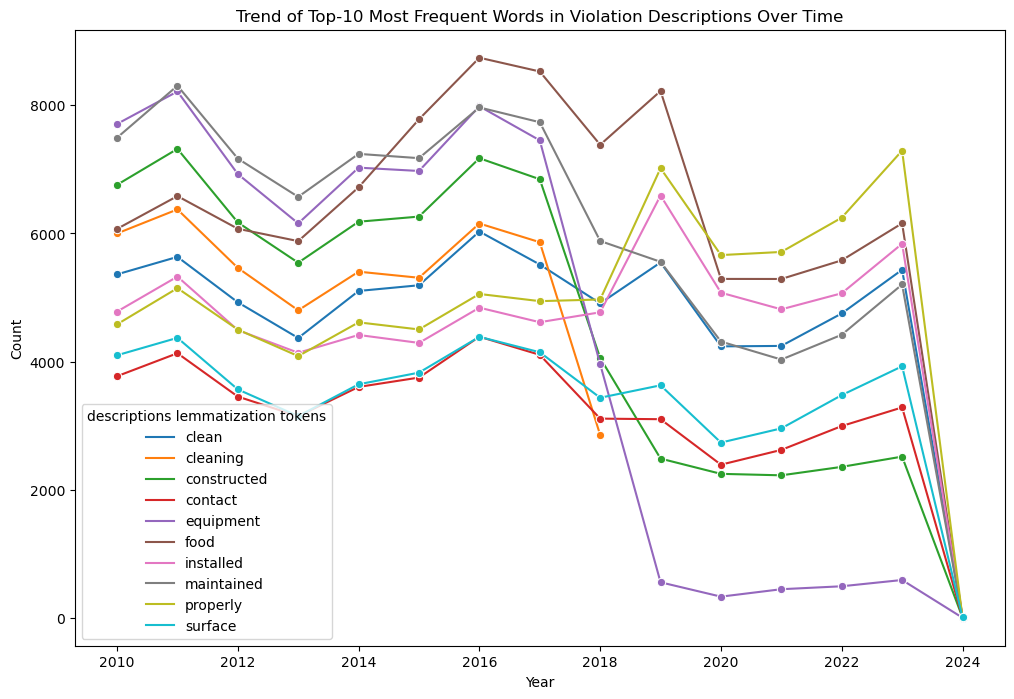

In [160]:
import seaborn as sns
import matplotlib.pyplot as plt

# Find the overall Top-10 most frequent violations
top_10_overall = grouped_tokens.groupby('descriptions lemmatization tokens')['count'].sum().nlargest(10).reset_index()

# Filter the data for the top 10 overall violations
filtered_data = grouped_tokens[grouped_tokens['descriptions lemmatization tokens'].isin(top_10_overall['descriptions lemmatization tokens'])]

# Create a seaborn lineplot for the trend
plt.figure(figsize=(12, 8))
sns.lineplot(x='Inspection Year', y='count', hue='descriptions lemmatization tokens', data=filtered_data, marker='o')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Trend of Top-10 Most Frequent Words in Violation Descriptions Over Time')

# Show the plot
plt.show()